In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score as crs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV as RCV

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

* dataset shape less number of rows so rather than spliting in train test we will use k fold cross validation

In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

* No missing value in dataset

In [6]:
df.target.unique()

array([1, 0], dtype=int64)

* we have to predict that person has heart problem or not 
  it is binary classification problem

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

* data is balanced

In [9]:
cont_features=[x for x in df.columns if len(df[x].unique())>25]
cont_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

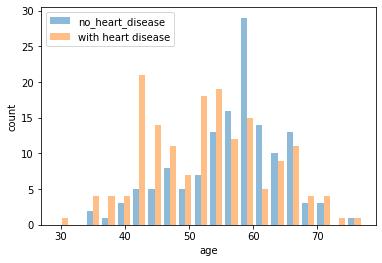

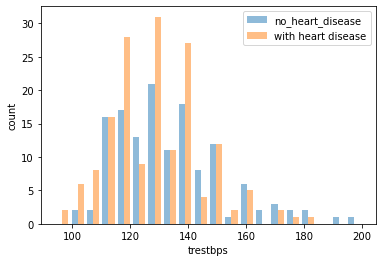

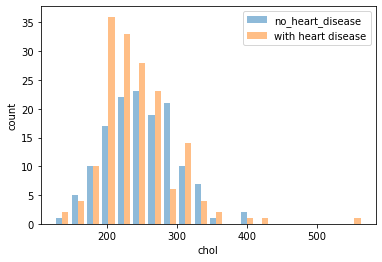

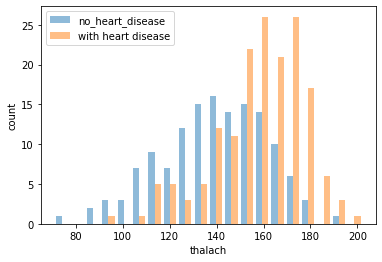

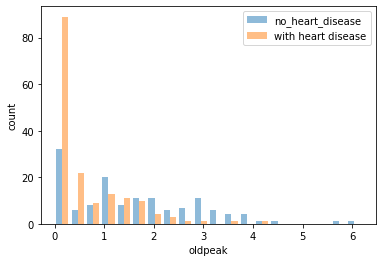

In [10]:
for x in cont_features:
    plt.hist([ df[df.target==0][x] , df[df.target==1][x] ],bins=20,alpha=0.5,
             label = ["no_heart_disease","with heart disease"])
    plt.xlabel(x)
    plt.ylabel("count")
    plt.legend()
    plt.show()

* people with age more than 40 has more heart problem
* in case of trestbps more than 120
* chol more than 200
* thalach more than 140
* and who have less oldpeak

In [11]:
dis_features=[ x for x in df.columns if len(df[x].unique())<=25]
dis_features

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

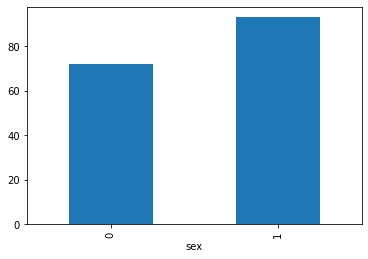

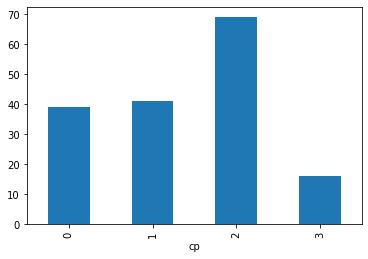

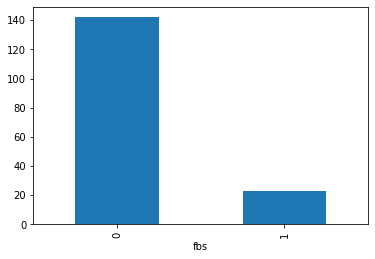

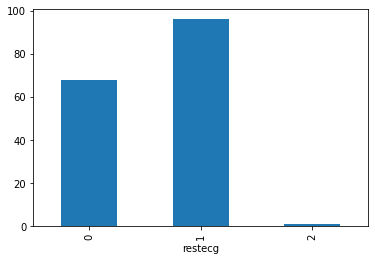

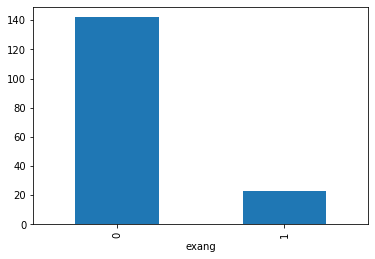

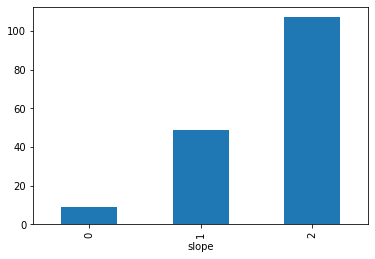

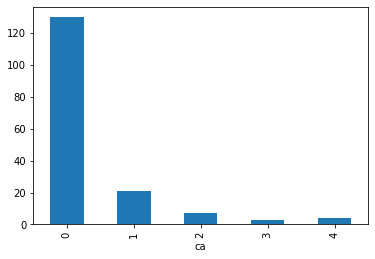

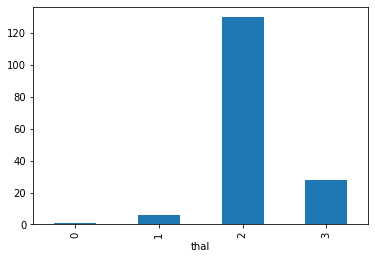

In [12]:
for x in dis_features:
    if x!='target':
        df.groupby(x)['target'].sum().plot(kind='bar')
        plt.xlabel(x)
        plt.show()

* discreate features tell more information about people who having heart problems

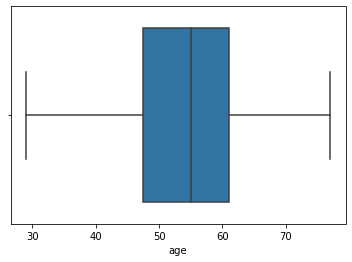

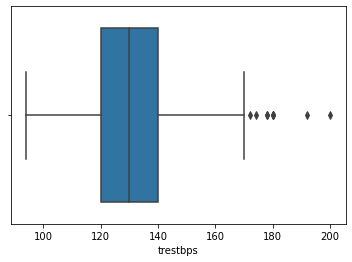

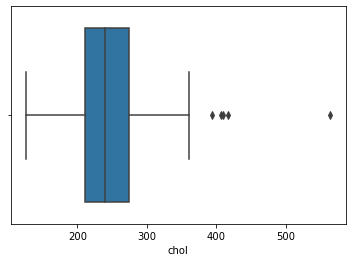

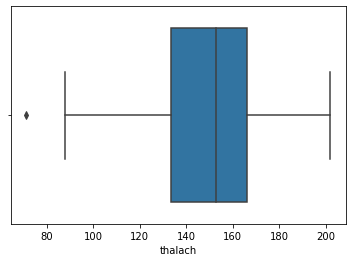

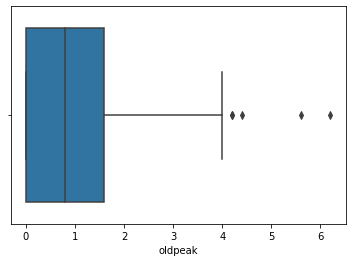

In [13]:
#outlier 
for x in cont_features:
    sns.boxplot(df[x])
    plt.xlabel(x)
    plt.show()

In [14]:
for x in cont_features:
    q1,q3=df[x].quantile([.25,.75])
    iqr=q3-q1
    lower=q1-1.5*iqr
    upper=q3+1.5*iqr
    df[x]=np.where(df[x]>upper,upper,df[x])
    df[x]=np.where(df[x]<lower,lower,df[x])

feature Selection

<AxesSubplot:>

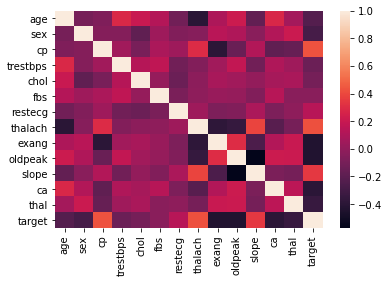

In [15]:
sns.heatmap(df.corr())

* Data is Ready for model trainning
* We will not split dataset in train test as dataset is small
* we will calculate Cross val score

In [16]:
X=df.copy()
X.drop(['target'],axis=1,inplace=True)
Y=df['target']

In [17]:
logReg=LogisticRegression(random_state=42,max_iter=1000)
scorelog=crs(logReg,X,Y,cv=5)
scorelog=np.mean(scorelog)
scorelog

0.8348633879781421

In [18]:
DTree=DecisionTreeClassifier()

params={'max_depth':[x for x in range(4,20)],
        'min_samples_split':[x for x in range(4,10)],
        'min_samples_leaf':[x for x in range(4,10)],
       }

rcv=RCV(DTree,param_distributions=params,cv=5,random_state=42)
search=rcv.fit(X,Y)
scoreDTree=search.best_score_
print(search.best_params_)
print(scoreDTree)

{'min_samples_split': 6, 'min_samples_leaf': 7, 'max_depth': 14}
0.8083060109289617


In [19]:
RF=RandomForestClassifier()

params={'n_estimators':[x for x in range(90,200)],
        'max_depth':[x for x in range(4,20)],
        'min_samples_split':[x for x in range(4,10)],
        'min_samples_leaf':[x for x in range(4,10)],
       }

rcv=RCV(RF,param_distributions=params,cv=5,random_state=42)
search=rcv.fit(X,Y)
scoreRF=search.best_score_
print(search.best_params_)
print(scoreRF)

{'n_estimators': 196, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_depth': 17}
0.844808743169399


In [20]:
XGB=XGBClassifier(verbosity = 0)

params={
        'n_estimators':[x for x in range(90,200)],
        'max_depth':[x for x in range(4,20)],
        'min_child_weight':[x for x in range(1,10)],
        'learning_rate':[0.1,0.01,0.001,.2,.3,.4],
         'reg_lambda':[0,0.05,0.1,0.2,.3,.5,.6,.7,.8,.9,1]
       }

rcv=RCV(XGB,param_distributions=params,cv=5,random_state=42)
search=rcv.fit(X,Y)
scoreXGB=search.best_score_
print(search.best_params_)
print(scoreXGB)

{'reg_lambda': 0.05, 'n_estimators': 164, 'min_child_weight': 6, 'max_depth': 17, 'learning_rate': 0.2}
0.8349180327868853


Logistic Regression,Random Forest And XGBoost perform good

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

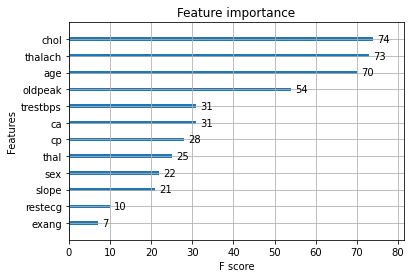

In [21]:
## Feature Importance With xgboost

plot_importance(search.best_estimator_)

for confusion matrix we will use Xgboost

In [22]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=.25,random_state=42)
model=XGBClassifier(reg_lambda= 0.05, n_estimators=164, min_child_weight= 6, max_depth= 17, learning_rate= 0.2)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)


0.8289473684210527

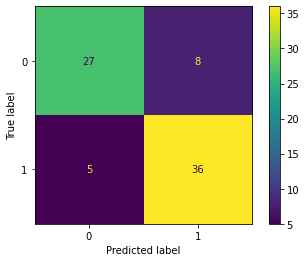

In [23]:
plot_confusion_matrix(model,xtest,ytest)

In [24]:
tp=36
fp=8
fn=5
precision_rate = tp / (tp + fp)
recall_rate = tp / (tp + fn)
print(precision_rate)
print(recall_rate)

0.8181818181818182
0.8780487804878049


Recall is greater as it important to identify person having heart problem